In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;  
}

<IPython.core.display.Javascript object>

In [2]:
import sys
sys.path.append('/Users/af/Work/code/mcmc/build')
#sys.path.append('/Users/af/Work/code/mcmc/debug')

import mcmc
#help(mcmc)
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
from datetime import datetime,timedelta
giturl_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

corona_cases_df=pd.read_csv(giturl_deaths, index_col=[0,1,2,3])  
#   use first four columns as multiindex




country_official_list = (corona_cases_df.index.get_level_values('Country/Region').values)

wanted_countries = ['China', 'Korea','Italy', 'France', 'US']

countries_list = [np.unique(np.array([s for s in country_official_list if cou in s])) 
                                                 for cou in wanted_countries]
countries_list = np.array(countries_list).flatten()
countries_list.sort()
countries_list


cases_percountry = {}
df_dict = {}
for country in countries_list:
    cou = corona_cases_df.loc[pd.IndexSlice[:, country], :].sum()
    cases_percountry[country] = cou[cou > 0]
    datesformat = [datetime.strptime(da, '%m/%d/%y') 
                   for da in cases_percountry[country].index]
    
    df_dict[country] = pd.DataFrame(cases_percountry[country], 
                                    columns=['Cases'], index=datesformat)
    df_dict[country]['DayCount'] = np.arange(1, 
                                             cases_percountry[country].shape[0]+1)
    
    
country = 'Korea, South'
country = 'Italy'
#print(df_dict['Italy']['Cases'])  #print cases every three days

# for country in countries_list:
#     print(country)
#     dates=df_dict[country].index
#     plt.semilogy(dates, np.array(list(df_dict[country]['Cases'].values)), label=country)
#     plt.legend(loc='lower right')
#     plt.tick_params(rotation=45, labelsize=12)
#     #plt.ylabel(casestr, fontsize=14)
# plt.xlim([dates[0]-np.timedelta64(3,'D'), dates[-1]+np.timedelta64(10,'D')])
# plt.show()


nPop = 60000000
nPredictDays = 60
maxdelay = 40

#testdays = np.arange(60)

#starting at 21 feb 

#print(np.array(list(df_dict[country]['Cases'].values)))
deaths_data = np.array(list(df_dict[country]['Cases'].values))

#np.array([1,2,3,7,10,12,17,21,29,34,52,79,107,148,197,233,366,463,631,827,827,1266,1441,1809,2158,2503,2978,3405,4032,4825,5476,6077,6820,7503,8215,9134,10023,10779,11591,12428,13155,13915, 14681, 15362 ])
#nPop/(1+np.exp(-(testdays-20)*0.2))*0.0015

deaths_past = np.zeros(maxdelay + deaths_data.size)
deaths_past[maxdelay:] = deaths_data
#keep the relative error low at 1%. if all measurements were independent it would be low.
#but errors even out in time mostly - here we assume a tiny fraction of cases does not 
#besides the constant 

#shot noise: every delta has sigma = sqrt(delta). day i var is cumsum of sigma^2=delta, so the original total. 
#additionally, we assume per day 10 deaths may go unnoticed early in the first two weeks - systematic error... 
#we could also assume a percentage of delta per day is a random added error, but these are not independent and even out late
#while not important initally. 
shotnoise = np.sqrt(deaths_data)
unnoticed = 10*np.ones(deaths_data.shape)
unnoticed[14:] = 0
deaths_error = np.cumsum(unnoticed) + shotnoise
time_past = np.arange(deaths_past.size)-maxdelay
time_data = np.arange(deaths_data.size)
time_all = np.arange(deaths_past.size+nPredictDays)-maxdelay


#plt.plot(time_past, deaths_past)
#plt.errorbar(time_data, deaths_data, deaths_error)



In [4]:
def loglike(probSerious, probAsymp, hospitalSlope, probLethalIfSerious): 
    
    print('starting optim with probSerious = {}, probAsymp = {}, hospital slope = {}, probLethalIfSerious'.format(probSerious, probAsymp, hospitalSlope, probLethalIfSerious))
    params = mcmc.DiseaseParams()
    params.probLethalDailyWhenSeriousUntreated = 0.4
    params.probSerious = probSerious #unknown, higher for older population - should be possible to extract from Diamond Princess. 
    #I think about 30 were serious... 30/700 would then be upper limit, so at most 5% for old people. 
    #Conistency check: 6(factor below)*11(dead on diamond princess) = 66... okay, more than 30. So 10% serious for old people.
    # this number is between 0.02 and 0.1. need to line search max likelihood

    params.probLethal = params.probSerious*probLethalIfSerious #out of 50~49 serious cases, 7 dead in Aachen study https://www.aerzteblatt.de/archiv/213454
    params.probAsymp = probAsymp
    params.timeIncub = 6  #chinese like studies...
    params.timeIncubSigma = 4

    #obained to match median 4, IQR 7 from Aachen study https://www.aerzteblatt.de/archiv/213454
    params.timeMildToSerious = 7.1 
    params.timeMildToSeriousSigma = 13

    #Drosten study https://www.medrxiv.org/content/10.1101/2020.03.05.20030502v1 
    #: 9 patients, all virus present after 5 days of symptoms. Let's say then that chance shorter ~ 10%. 
    # seroconversion early week 2 progressive decrease in viral load in samples. 10 days most gone. 
    #let's take lognormal with 5 at 10% CDF and 10 at 90% CDF 
    params.timeMildDuration = 7.4 
    params.timeMildDurationSigma = 2

    # Aachen Median acht Tage (IQR 5–11) for all, including most that did not die. 
    # This is longer with larger spread than the recovered group. We choose Median 8.6, IQR 6.6 to get 
    params.timeSeriousToDeath = 10
    params.timeSeriousToDeathSigma = 6

    # less important: 
    # Aachen Median 7 Tage [IQR 6–11])
    params.timeSeriousToRecovered = 8
    params.timeSeriousToRecoveredSigma = 4.5

   


    deathdata = np.zeros((2, deaths_data.size))
    deathdata[0, :] = deaths_data
    deathdata[1, :] = deaths_error

    discontdays = np.array([1, 9, 12, 29]) #removed 32 
    discontvals = np.array([1,0.6,0.5,0.4])

    discontdata = np.zeros((3, discontdays.size))
    discontdata[0, :] = discontdays
    discontdata[1, :] = discontvals
    discontdata[2, :] = discontvals # > 0 means sample this (else fixed)
    #discontdata[2, 1] = -1         # < 0 means fix 

    data = mcmc.DiseaseData(deathdata,  discontdata)

    data.initialBetaMild = 2
    data.initialBetaHigh = 10
    data.initialDelay = 23
    data.fixBehaviorInAdvance = 10
    
    
    covid = mcmc.DiseaseSpread(data, params, nPop, 7500, hospitalSlope, maxdelay, nPredictDays)


    state = mcmc.State()
    state.add(covid)
    smooth = mcmc.SmoothnessPrior("behavior",  50, deaths_data.size-data.fixBehaviorInAdvance)
    state.add(smooth)

    #print(state.getAll())
    state.sharedDependencyMaxDepth = 5
    
    for i in range(4):
        target = mcmc.CoolingTarget(9)
        target.set_posterior(state)
        chain = mcmc.Chain(target, 0)
        chain.computeMean = False
        chain.recordSamples = True
        chain.run(0,0,100,1)
        print(chain.getLoglikes())
   
    return chain.getLoglikes()[-1], chain



In [5]:

#l, chain = loglike(0.044, 0.3, 100)

TypeError: loglike() missing 1 required positional argument: 'probLethalIfSerious'

In [ ]:
n1 = 5
n2 = 4
n3 = 4
n4 = 3

res = np.zeros((n1,n2,n3,n4))

for i1, probSerious in enumerate(np.linspace(0.02, 0.06, n1)):
    for i2, probAsymp in enumerate(np.linspace(0.1, 0.4, n2)):
        for i3, hosp in enumerate(np.linspace(10, 100, n3)): 
            for i4, probLethalIfSerious in enumerate(np.linspace(0.14, 0.1922, n4)):
                
                l, chain = loglike(probSerious, probAsymp, hosp, probLethalIfSerious)
                res[i1,i2,i3,i4] = l
                
                
                

starting optim with probSerious = 0.02, probAsymp = 0.1, hospital slope = 10.0, probLethalIfSerious
[-3112.99384156 -1669.28034231 -1669.28034231 -1630.50229876
 -1547.13532032 -1521.96492878 -1482.33509056 -1452.26568117
 -1439.92675753 -1421.11364523 -1396.09871911 -1382.71700024
 -1345.49055364 -1301.26593069 -1250.89356887 -1208.14983405
 -1178.3457634  -1160.86904168 -1136.34272385 -1067.89708552
 -1049.34428281 -1005.7289573   -928.07744381  -888.93528989
  -886.34493377  -843.13961792  -767.71208873  -650.21473394
  -644.8708268   -635.85963028  -633.50341297  -629.9270986
  -621.96399106  -621.96399106  -612.6408237   -592.4305955
  -589.67693694  -582.80090004  -575.05253607  -574.2249521
  -569.04356634  -569.04356634  -565.76552647  -564.49735927
  -561.75527172  -560.4752292   -553.77699202  -550.53027723
  -538.93526483  -534.33729386  -530.21507767  -525.14933329
  -522.65198061  -515.38368082  -511.54384571  -502.17972312
  -496.17173113  -488.31528491  -476.29793713  -4

[-26.55168136 -26.65762634 -26.60973636 -28.34198506 -27.05280119
 -26.95851248 -26.93998956 -26.78704827 -28.09652334 -27.36977291
 -26.92405976 -26.90794377 -26.86165291 -26.74209613 -26.23060104
 -26.54211035 -26.44838284 -26.22879343 -26.26466669 -26.19081929
 -26.29347252 -26.11438806 -26.11238223 -26.10160273 -26.19017913
 -26.10084088 -26.24085226 -26.20248803 -26.17628085 -26.15528684
 -26.24643927 -26.28997782 -26.2430132  -26.32757918 -26.20416248
 -26.13530786 -26.08459867 -26.15668254 -26.1169095  -26.09463795
 -26.06141516 -26.03104166 -26.02035146 -26.03598476 -26.05901131
 -26.08336095 -26.08701788 -25.98316257 -25.98111256 -25.93883313
 -25.91233502 -25.91233502 -25.91610306 -25.91223752 -25.91487116
 -25.92145898 -25.91837585 -25.91641154 -25.92382451 -25.91645668
 -25.913245   -25.90601237 -25.88692704 -25.882136   -25.87612902
 -25.87576561 -25.87569213 -25.85849066 -25.85452193 -25.85832409
 -25.84511707 -25.8439721  -25.8445841  -25.84310263 -25.84676413
 -25.84405

[-73.51298243 -73.49229028 -73.51906054 -74.61574697 -73.8540386
 -75.13509329 -75.44851839 -74.00015305 -74.05936288 -74.68771476
 -73.94119722 -73.7766534  -74.00693131 -74.63714465 -74.1716715
 -74.45843794 -74.08610417 -73.78708246 -73.25608098 -73.26266584
 -73.37192839 -73.19181081 -73.02283958 -72.98439163 -73.05305236
 -72.92646041 -72.83398152 -73.0768677  -72.91190077 -72.91632355
 -73.01138827 -73.11967926 -73.1059188  -73.015088   -72.93730831
 -72.86659419 -72.90187669 -72.80062958 -72.78195077 -72.76421216
 -72.70272721 -72.74052196 -72.70152036 -72.71319065 -72.73829822
 -72.66499803 -72.65162825 -72.63581535 -72.67471261 -72.62954287
 -72.59840313 -72.59999777 -72.57427599 -72.55202607 -72.54012695
 -72.5248946  -72.47312279 -72.48117776 -72.4886122  -72.46925676
 -72.45543216 -72.44420214 -72.43530327 -72.43158559 -72.42548864
 -72.41024972 -72.40358213 -72.40275513 -72.40247982 -72.4062144
 -72.40425915 -72.3988476  -72.39569569 -72.37501889 -72.36772619
 -72.34546009

[-2356.62336511 -2261.29283776 -1233.32325511 -1200.33432961
 -1200.33432961 -1183.59965189 -1172.51736062 -1171.66561177
 -1162.57623093 -1160.37638706 -1153.78834785 -1146.65374809
 -1144.75792878 -1136.59047505 -1121.22518525 -1118.19987466
 -1102.4728768  -1096.89759137 -1088.85556452 -1080.35722867
 -1072.11595136 -1053.25733557 -1047.24350951 -1042.50876572
 -1034.77443766 -1021.39012938 -1011.17675074 -1002.30528002
 -1000.98239827  -988.28455371  -986.65966669  -979.4214194
  -966.68912398  -965.51040515  -953.94710937  -923.94949639
  -919.61221642  -903.65819808  -900.44118473  -896.91865086
  -891.99601741  -891.84535103  -887.43638003  -885.51917298
  -882.72149802  -877.43788004  -866.21647434  -861.97779894
  -844.64358641  -832.84239878  -829.68456611  -825.31342723
  -819.05274124  -800.09808937  -796.74757469  -777.63048169
  -772.29175748  -761.42475593  -754.60964353  -746.97422621
  -737.37636791  -732.75240883  -732.15053568  -729.50266288
  -718.67855009  -716.752

[-49.16516301 -49.11214246 -49.2793413  -50.75080289 -49.52878573
 -49.95130572 -48.69611614 -48.97111994 -48.37710263 -47.96665935
 -48.13025902 -48.36074323 -47.93580359 -47.50023361 -47.11718694
 -47.15456564 -47.53483401 -47.14812716 -47.04283758 -45.36209635
 -44.58991784 -44.3531149  -42.99876478 -42.93244902 -43.04344931
 -42.0027105  -41.22011358 -40.08464011 -39.66086159 -39.69013105
 -39.62899501 -39.88424281 -39.49234517 -39.10758342 -38.52298089
 -37.71154178 -37.56038126 -37.28779356 -37.10100241 -37.07203266
 -36.92367425 -36.96340736 -36.76942606 -36.76942606 -36.76414058
 -36.71247713 -36.65447979 -36.43805333 -36.28700225 -36.13120503
 -35.57422801 -35.46884226 -35.39986768 -35.25386413 -35.21713155
 -35.13887307 -35.03876097 -34.78691564 -34.5933072  -34.57403388
 -34.46791253 -34.46791253 -34.46002191 -34.42860819 -34.2947527
 -34.23054867 -34.16083722 -34.0995028  -34.03685927 -34.02471439
 -33.99421618 -33.97388566 -33.95265014 -33.92932042 -33.90732355
 -33.909514

[-133.02411049 -127.62731253 -129.29790001 -127.24779784 -126.16080444
 -119.12304243 -118.95697767 -118.55408535 -117.53520607 -110.60127666
 -108.32205704 -106.2431666  -106.05821951 -103.68781089  -98.95846415
  -98.26816949  -97.14434401  -95.27613193  -94.43889827  -93.09197965
  -90.44597592  -89.91208683  -89.04132189  -88.68155096  -88.84366286
  -86.71063386  -85.28062637  -82.61893531  -82.2424982   -81.99890812
  -81.84798685  -82.02784454  -81.26937045  -81.17723955  -78.52162667
  -76.87824003  -75.8897343   -75.34916456  -75.02862181  -74.97025048
  -74.56165102  -74.52281688  -74.16771614  -74.00817699  -73.77085173
  -73.74238138  -73.50707726  -72.9441018   -72.64980999  -72.47940034
  -71.21260426  -70.99235944  -70.86168462  -70.48365092  -70.29873791
  -70.00770791  -69.82329355  -68.83922801  -68.32000239  -68.29064013
  -67.90425771  -67.90425771  -67.86227472  -67.71954807  -67.31627486
  -67.12232023  -66.97276555  -66.76958431  -66.48749308  -66.45355828
  -66.

[-2506.56966198 -1019.44499193 -1019.44499193 -1002.54238483
  -959.37943677  -943.15289471  -912.3298427   -893.23277906
  -877.46837048  -864.22217324  -833.31011863  -813.78744434
  -781.19848398  -721.66364576  -665.54670978  -634.80432219
  -596.70230515  -585.69099805  -583.46326758  -577.4650782
  -566.25987676  -551.47552752  -549.97531064  -541.17575607
  -538.24076646  -523.62990998  -512.3790185   -503.96511963
  -502.0696414   -490.22781018  -488.70761412  -482.19960611
  -471.21983249  -469.55361099  -453.23705779  -442.08989677
  -438.15201393  -427.52220626  -423.20821645  -422.91577338
  -419.77570468  -418.96735949  -415.29508449  -414.95782247
  -412.83619975  -408.41774634  -400.62911175  -397.25824208
  -384.20163797  -373.50340589  -371.5349611   -368.58236593
  -364.85118477  -356.19794345  -353.58395538  -342.11876588
  -330.94822082  -326.4973532   -322.49343155  -317.32826949
  -310.74835931  -308.13913186  -308.07537399  -306.67672649
  -299.69241235  -298.129

[-4.00095505 -3.52514434 -3.5822392  -6.09086444 -3.53866294 -4.49952329
 -3.53790776 -3.70472544 -4.2094279  -3.56547171 -3.59952356 -3.63450021
 -3.63228417 -4.24040502 -3.97140255 -3.70594594 -3.99498952 -3.57656455
 -3.61160463 -3.74301514 -3.68115191 -3.64521013 -3.99320493 -3.50108927
 -3.50951992 -3.45668755 -3.52233951 -3.52233951 -3.44754864 -3.47128865
 -3.4470337  -3.52049664 -3.54784375 -3.70908518 -3.46165205 -3.46165205
 -3.46193251 -3.46290086 -3.46809898 -3.48192431 -3.47184462 -3.52985802
 -3.52841938 -3.50391945 -3.47635973 -3.46777207 -3.47858054 -3.48839819
 -3.48644658 -3.49053408 -3.49494932 -3.49217964 -3.48570229 -3.48032707
 -3.46285407 -3.45742978 -3.45607521 -3.46254549 -3.46255119 -3.47010665
 -3.45167601 -3.44373673 -3.44196547 -3.44069035 -3.43404583 -3.43466529
 -3.4354715  -3.43181702 -3.43282341 -3.43352148 -3.43337837 -3.43408964
 -3.42903621 -3.42837747 -3.42589673 -3.42573252 -3.42040866 -3.41975666
 -3.42015386 -3.41983324 -3.41945168 -3.42001712 -3

[-9.26754395 -6.5602997  -6.41750222 -8.36631034 -7.90864017 -6.46506837
 -6.41280631 -6.40657854 -6.6452093  -6.55407384 -6.13575693 -7.20324202
 -6.48052559 -6.49865894 -6.51637974 -6.72290022 -6.45634521 -6.49064891
 -6.42316089 -6.31173177 -6.28069262 -6.19596474 -6.24471979 -6.15487126
 -6.28204483 -6.09696775 -6.00119005 -6.08939443 -6.0662235  -6.04171053
 -5.94665377 -5.96843656 -5.96410932 -5.95937279 -5.81000426 -5.77716207
 -5.77242889 -5.79113896 -5.81713966 -5.83035561 -5.78828169 -5.79378611
 -5.80271369 -5.81853328 -5.83888559 -5.84681646 -5.83903614 -5.78589397
 -5.75408719 -5.76110451 -5.76949991 -5.77487973 -5.7837048  -5.77018949
 -5.77073683 -5.76007811 -5.75285375 -5.75155823 -5.75322841 -5.75565838
 -5.75603739 -5.75404405 -5.7280926  -5.72387051 -5.70209744 -5.70089446
 -5.69367796 -5.693293   -5.68449728 -5.68498359 -5.68230311 -5.68176582
 -5.67941188 -5.6791908  -5.67860358 -5.67728128 -5.66546155 -5.65464071
 -5.65365404 -5.65365404 -5.65368562 -5.65379441 -5

[-3906.5087635   -998.93621236  -998.93621236  -884.51522865
  -805.85326142  -784.748656    -772.09758353  -635.39153801
  -577.00994287  -490.87703585  -428.59000343  -307.02364839
  -304.40935943  -277.70711379  -264.7461157   -240.82318013
  -236.14076794  -226.57775322  -215.88145772  -194.94783269
  -169.61688044  -156.45797213  -103.90145681   -93.36840889
   -84.49063382   -79.49683108   -75.40142971   -61.23254798
   -60.03281562   -55.62704911   -52.82469694   -47.74765018
   -37.95782791   -37.92708691   -27.38575466   -25.40843378
   -21.1280562    -18.60917358   -17.11859741   -17.07192683
   -17.01803124   -16.55511622   -16.28276348   -16.06808068
   -15.35931068   -14.74206835   -14.66924647   -14.55706181
   -14.32541761   -14.02441883   -14.03032393   -13.98836035
   -13.61888814   -13.41069007   -13.09257705   -13.10377606
   -12.90736695   -12.54683789   -12.51634377   -12.3306767
   -12.28312433   -12.23232288   -12.21605788   -12.0744029
   -12.02584369   -11.9798

 -44.86169054 -44.8563286  -44.85490486 -44.8520631 ]
starting optim with probSerious = 0.02, probAsymp = 0.2, hospital slope = 70.0, probLethalIfSerious
[-3474.20994811  -234.07345594  -134.77979593   -90.63046361
   -90.63046361   -86.06104651   -85.95255224   -84.74097636
   -83.71796427   -82.89128461   -81.16376719   -77.94324686
   -77.80387143   -69.06388171   -59.8120853    -58.93773713
   -53.33823719   -51.72245156   -51.44448132   -49.81833346
   -47.67343144   -41.57984497   -41.30296827   -36.60278247
   -35.74952038   -33.25122689   -31.84577787   -31.83057264
   -31.85871426   -29.64334208   -28.34012645   -26.76509984
   -24.3846519    -23.88771348   -22.71086976   -20.78861868
   -20.82460474   -19.21836953   -19.18304464   -19.18349805
   -19.1122764    -19.03305848   -19.03305848   -19.04036336
   -19.03173664   -19.05388405   -19.03566308   -19.03937096
   -18.95363592   -18.88274218   -18.8726366    -18.75794729
   -18.68829153   -18.51797086   -18.51403794   -18.3

[-6.53920037 -6.45714318 -7.03438929 -9.33200603 -6.48995864 -6.55801272
 -6.52690593 -6.56428493 -6.90094016 -6.65531755 -6.76109801 -6.55910297
 -6.76077381 -6.91263711 -6.47379334 -6.61935636 -6.40833157 -6.41768701
 -6.39590372 -6.35913677 -6.44755471 -6.43284494 -6.53309602 -6.63024036
 -6.29070949 -6.28526652 -6.33254527 -6.3191867  -6.2670497  -6.32917827
 -6.33370544 -6.38012003 -6.3114405  -6.19465552 -6.17049175 -6.13318042
 -6.18723482 -6.08097867 -6.06874589 -6.06809302 -6.06485929 -6.04896787
 -6.0514554  -6.04684826 -6.07206303 -6.082618   -6.08069773 -6.08726779
 -6.07674756 -6.04499064 -6.08470981 -6.07184458 -6.07069789 -6.0624308
 -6.04954151 -6.05324788 -6.04321119 -6.04267408 -6.04124904 -6.04171741
 -6.03846989 -6.03289298 -6.03492812 -6.0187147  -6.0156086  -6.00274624
 -6.00578968 -6.00280125 -5.9955103  -5.98697382 -5.98679498 -5.9851647
 -5.98721434 -5.98511969 -5.97833748 -5.96477567 -5.95654045 -5.95625062
 -5.95821521 -5.95712829 -5.95678159 -5.9569341  -5.9

[-9.38545723 -8.27589266 -8.62774826 -8.96472778 -8.50060623 -9.29577778
 -8.65511797 -8.30050039 -9.3786873  -8.28137191 -8.42751697 -8.1812143
 -8.71559019 -8.32851938 -8.53071572 -8.79252838 -8.38268264 -8.36416069
 -8.36710177 -8.51231208 -8.57278692 -8.50895214 -8.40539317 -8.26958984
 -8.37335038 -8.13546918 -8.10106044 -8.10106044 -8.084826   -8.03414296
 -8.13568228 -8.14465457 -8.10869273 -8.09788717 -8.10686376 -8.04158299
 -8.03552034 -8.10644211 -8.06087476 -8.06338145 -8.05299565 -8.08472554
 -8.08434817 -8.09470766 -8.11648443 -8.11232126 -8.09602278 -8.0246884
 -8.03691924 -8.02723237 -8.03756069 -8.03465221 -8.01855459 -8.02042781
 -8.01165892 -7.99188533 -7.99233991 -8.00427972 -8.00656936 -8.00980083
 -7.99782937 -7.99264061 -7.98831897 -7.98432164 -7.96453044 -7.96454744
 -7.9661365  -7.96171963 -7.96088198 -7.96082758 -7.96228999 -7.95875776
 -7.95832261 -7.95545006 -7.95568924 -7.95661381 -7.95161847 -7.94744694
 -7.94776055 -7.94848456 -7.94869147 -7.94911995 -7.9

 -16.806678   -16.80179575 -16.79957456 -16.79812841]
starting optim with probSerious = 0.02, probAsymp = 0.30000000000000004, hospital slope = 10.0, probLethalIfSerious
[-5952.35427024 -1048.49027941  -266.71136394  -231.06346954
  -231.06346954  -213.18007669  -208.60088355  -203.6682697
  -193.29135387  -187.9836905   -180.87391677  -175.65361137
  -173.78929249  -161.39634251  -143.48401255  -138.14890649
  -122.55965714  -120.29740953  -119.27877569  -115.09294601
  -110.30227232   -98.84361498   -93.27811081   -84.38397945
   -82.76742198   -78.53341589   -75.98067      -76.17395217
   -76.16312828   -71.64246277   -68.96046358   -65.89982171
   -60.85223741   -60.29784139   -58.4568166    -55.07778203
   -54.76683612   -52.47017033   -52.42551074   -52.40278167
   -52.28977267   -52.19450779   -52.19916036   -52.18633322
   -52.07669436   -51.3074792    -50.02462468   -50.03969816
   -48.44137096   -46.48512571   -46.45558369   -46.36305947
   -44.65382358   -43.4984579    -43.4

[-6917.38324735 -2812.27194565  -540.40130032  -444.37820769
  -444.37820769  -309.69786731  -284.6402315   -277.35409398
  -260.46834462  -245.58084935  -230.803       -222.52126131
  -212.52795786  -191.47279747  -159.42171372  -153.04740514
  -134.13744774  -133.59020716  -133.3002553   -128.44606497
  -123.23120185  -112.22267477  -106.71586299   -95.62031705
   -94.09858917   -89.21304338   -86.45794377   -86.46096351
   -86.41865212   -82.66534381   -80.62192948   -78.04041401
   -73.72461097   -72.90912834   -71.19393545   -67.80993758
   -67.65006843   -64.50940716   -64.49979255   -64.46537546
   -64.23283992   -64.07238267   -64.03910371   -64.03286031
   -63.92996645   -63.07186037   -61.80568336   -61.77029828
   -60.14329374   -58.10899519   -58.10529341   -57.98269908
   -56.37712479   -55.25457266   -55.2356241    -53.86834359
   -53.3060275    -52.68240053   -52.67427844   -51.63686281
   -50.71607341   -50.21765746   -49.37039764   -49.24790293
   -48.29575381   -47.59

[-13.07750498 -11.41566252 -11.47001056 -12.41687044 -11.89231375
 -11.45031085 -11.21969964 -11.23593403 -12.41466719 -11.22228408
 -11.2046054  -11.13798001 -11.66118371 -11.33638369 -11.17912339
 -11.19253997 -11.38474769 -11.1785201  -11.25941598 -11.08772294
 -11.20769695 -11.15378098 -11.04962179 -11.08689475 -11.1685234
 -10.97434636 -11.01808496 -11.06968634 -11.12639198 -11.09062824
 -11.05217857 -11.07188508 -11.05944025 -11.08381692 -10.95331694
 -10.81104997 -10.80192791 -10.81626295 -10.82149629 -10.81814044
 -10.79413958 -10.83793094 -10.847235   -10.85929192 -10.86571383
 -10.88138164 -10.86964947 -10.83227744 -10.82739626 -10.82539004
 -10.82560884 -10.83672391 -10.84950659 -10.82156218 -10.81599954
 -10.79627495 -10.79304408 -10.81102185 -10.81193621 -10.81641232
 -10.80297676 -10.80210855 -10.79612245 -10.79567579 -10.79785834
 -10.79498291 -10.79147177 -10.79116282 -10.78767289 -10.78829309
 -10.78193857 -10.78174238 -10.78070893 -10.78116039 -10.77698781
 -10.777990

[-6917.38324735 -2838.81000242  -378.4894873   -280.84483777
  -280.84483777  -215.01847095  -213.47262155  -210.60801024
  -203.86475551  -202.07495472  -197.8783023   -188.21243868
  -179.22629287  -160.09757556  -138.62836655  -138.10585622
  -119.80702031  -115.49800326  -115.28123189  -113.21061928
  -109.42438605   -98.76461266   -95.43027337   -83.69766568
   -82.16580613   -77.8158776    -75.28674927   -75.20627735
   -75.12299616   -70.95437882   -68.64656077   -65.58707942
   -61.48324652   -60.5779311    -58.66339686   -55.18248836
   -55.19944777   -51.68134967   -51.60170452   -51.60001927
   -51.45929421   -51.28904958   -51.28904958   -51.28999795
   -51.28413964   -51.28170794   -51.24817172   -51.24928147
   -51.10251962   -50.86540069   -50.86759813   -50.62086129
   -50.46435785   -50.1499905    -50.1487891    -49.68980237
   -49.53183382   -49.09638489   -49.08244598   -48.63328487
   -48.24848209   -48.05175398   -47.63935614   -47.59569332
   -47.13401057   -46.64

[ -9.96266182  -9.54675012  -9.63209456 -12.00470816  -9.58235526
  -9.77913359  -9.55054743  -9.63703465 -10.18551097 -10.24465681
  -9.65295494  -9.80177805  -9.89316631  -9.81817509  -9.58420418
  -9.58389217  -9.62438583  -9.63078089  -9.7440669   -9.5723329
  -9.72083609  -9.78075772  -9.59132175  -9.48155838  -9.54078572
  -9.51514236  -9.48438964  -9.61154368  -9.5725939   -9.52133421
  -9.48259979  -9.47604467  -9.47585877  -9.56045211  -9.59640549
  -9.55744538  -9.56950752  -9.52998797  -9.51686608  -9.48461011
  -9.48119456  -9.53583231  -9.55339849  -9.53626243  -9.53884933
  -9.54795628  -9.56297401  -9.53935734  -9.53710827  -9.52612742
  -9.53098806  -9.53701445  -9.52403037  -9.52450276  -9.51521573
  -9.50190329  -9.4956008   -9.50482111  -9.50685029  -9.5071934
  -9.49830133  -9.49127945  -9.48404221  -9.47855746  -9.47199975
  -9.46858779  -9.46596969  -9.46050266  -9.46108392  -9.4614313
  -9.46330119  -9.45973513  -9.45130036  -9.44931657  -9.44956
  -9.44494559  -

   -23.97383129   -23.84103373   -23.49454713]
[-24.73623543 -23.41136906 -23.97688582 -23.70720154 -22.45336604
 -21.62609479 -21.36657199 -21.06615585 -21.4003111  -20.50181789
 -20.04396966 -19.09504079 -19.24462333 -16.88901929 -14.81013636
 -14.96261855 -13.79089073 -13.88749851 -13.78177825 -13.79617011
 -13.7428324  -13.81647203 -13.43398317 -12.82060873 -12.67547219
 -12.53953301 -12.54735884 -12.54735884 -12.43320888 -12.40600111
 -12.37757691 -12.41826685 -12.28590273 -12.33708145 -11.89611828
 -11.71669703 -11.72574863 -11.69757612 -11.66525655 -11.66533371
 -11.66619236 -11.66619236 -11.66469992 -11.64955035 -11.66944987
 -11.6777616  -11.68009347 -11.6104695  -11.61195985 -11.5847185
 -11.58105034 -11.58206996 -11.56440625 -11.50986375 -11.50157519
 -11.46529184 -11.4585739  -11.47391322 -11.47562439 -11.44798998
 -11.41674989 -11.4050927  -11.4062553  -11.40537151 -11.3759999
 -11.37528194 -11.37376509 -11.37376509 -11.37237093 -11.36988693
 -11.35438156 -11.31778297 -11.

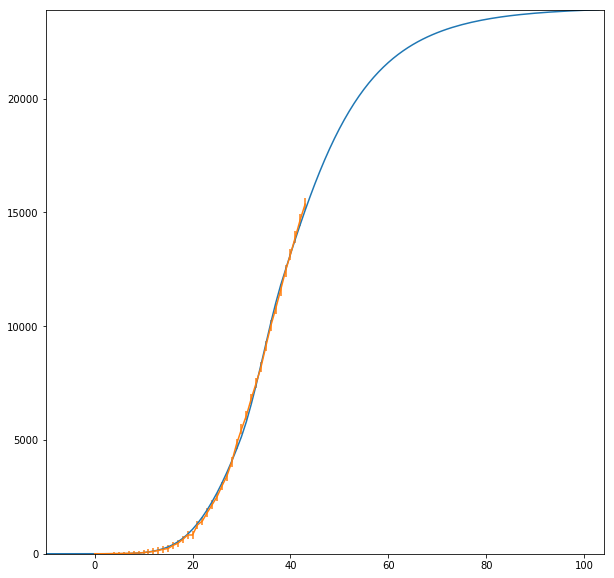

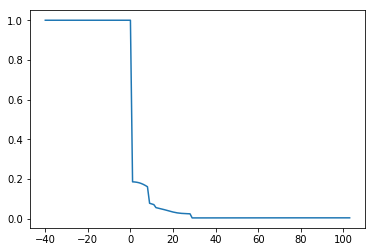

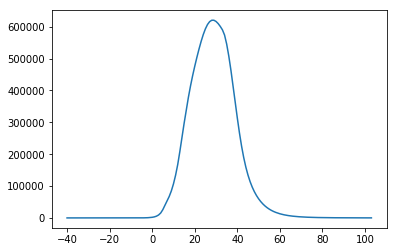

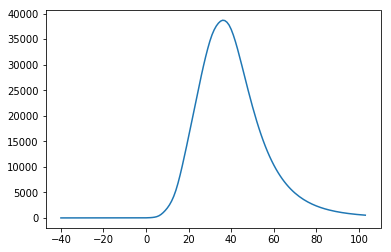

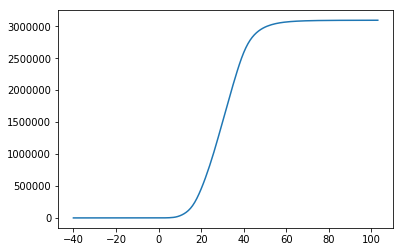

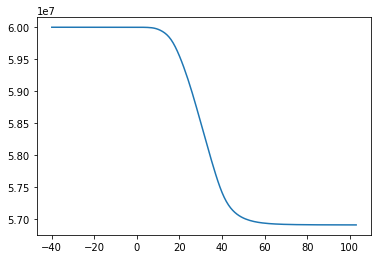

In [14]:
#plt.plot(time_all, chain.getMean("dead")[:] - np.mean(chain.getSamples("dead"),0))
#plt.show()

plt.figure(figsize=(10,10))
plt.plot(time_all, chain.getSamples("dead")[-1,:])
#for i in range(110): 
#    plt.plot(time_all, chain.getSamples("dead")[-1-35*i,:])


plt.errorbar(time_data, deaths_data, deaths_error)
plt.xlim([-10, deaths_data.size+60])

lims = plt.gca().get_xlim()
i = np.where( (time_all > lims[0]) &  (time_all < lims[1]) )[0]
plt.gca().set_ylim( chain.getMean("dead")[i].min(), chain.getMean("dead")[i].max() )

plt.show()


plt.plot(time_all, chain.getSamples("totalBehavior")[-1,:])
plt.show()

plt.plot(time_all, chain.getSamples("mild")[-1,:])
plt.show()
 
plt.plot(time_all, chain.getSamples("serious")[-1,:])
plt.show()
 

plt.plot(time_all, chain.getSamples("recovered")[-1,:])
plt.show()

plt.plot(time_all, nPop-chain.getSamples("recovered")[-1,:])
plt.show()